In [1]:
import cPickle as pickle
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import random

from collections import Counter
from nltk import word_tokenize

In [2]:
# Read glove vocab.
glove_vocab = set([ x.strip() for x in \
                      open("../../data/glove/glove.840B.vocab.txt").readlines() ])

In [3]:
# Check GloVe vocab.
"Santa" in glove_vocab

True

In [4]:
dev_data = pickle.load(gzip.open("../../data/our_model/dev.p.gz", "rb"))
questions = dev_data.questions
paragraphs = dev_data.paragraphs
tokenized_paras = dev_data.tokenized_paras
qid_to_paraidx = dev_data.question_to_paragraph
dev_input = dev_data.data

In [5]:
predicted_f1s = json.load(open("../our_model/logs/27.11.2017_3.00am/predicted_f1s_21.json"))
wrong_qids = set([ qid for qid in predicted_f1s if predicted_f1s[qid] < 1.0 ])

In [6]:
predicted_answers = json.load(open("../our_model/logs/27.11.2017_3.00am/dev_predictions_21.json"))

In [7]:
ans_lens = {}
for _, ans_idxs, qid, _ in dev_input:
    ans_len = ans_idxs[1]-ans_idxs[0]+1
    if not qid in ans_lens:
        ans_lens[qid] = ans_len
    else:
        ans_lens[qid] = min(ans_lens[qid], ans_len)
threshold = 15
pruned_answers = len([ qid for qid in ans_lens if ans_lens[qid] > threshold ])
print "Answers with > %d length:" % threshold, pruned_answers
print "Total answers:", len(ans_lens)
print "Ratio: %.2f%%" % (100 * float(pruned_answers)/len(ans_lens))

Answers with > 15 length: 26
Total answers: 10570
Ratio: 0.25%


In [8]:
start_attentions = pickle.load(open("../our_model/logs/27.11.2017_3.00am/dev_predictions_21.json_starts.p"))
end_attentions = pickle.load(open("../our_model/logs/27.11.2017_3.00am/dev_predictions_21.json_ends.p"))
print len(start_attentions)

10570


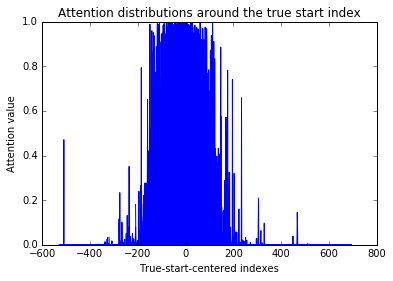

In [9]:
true_starts = dict([ (x, start_attentions[x][1]) for x in start_attentions ])
attention_xs, attention_ys = [], []
for qid in start_attentions:
    max_attention_idx = np.argmax(start_attentions[qid][0])
    min_start = true_starts[qid][np.argmin([ abs(idx - max_attention_idx) for idx in true_starts[qid] ])]
    attention_xs.append(np.arange(0, len(start_attentions[qid][0])) - min_start)
    attention_ys.append(start_attentions[qid][0])
for x,y in zip(attention_xs, attention_ys):
    plt.plot(x, y, 'b-')
plt.title("Attention distributions around the true start index")
plt.ylabel("Attention value")
plt.xlabel("True-start-centered indexes")
plt.show()

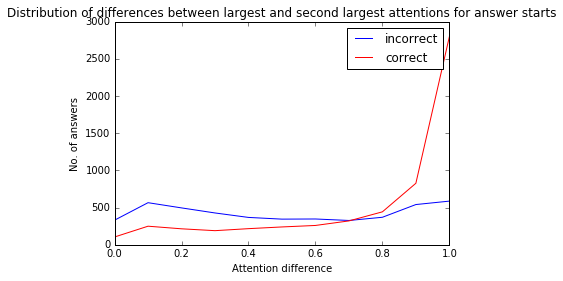

In [10]:
diff_values_correct, diff_values_incorrect = [], []
for qid in start_attentions:
    attn_distribution, _ = start_attentions[qid]
    if qid in wrong_qids:
        diff_values_incorrect.append(round(max(attn_distribution) - sorted(attn_distribution, reverse=True)[1], 1))
    else:
        diff_values_correct.append(round(max(attn_distribution) - sorted(attn_distribution, reverse=True)[1], 1))
counts_incorrect = Counter(diff_values_incorrect)
counts_correct = Counter(diff_values_correct)
handles = []
xs = sorted(counts_incorrect.keys())
ys = [ counts_incorrect[x] for x in xs ]
handles.append(plt.plot(xs, ys, 'b-', label="incorrect")[0])
xs = sorted(counts_correct.keys())
ys = [ counts_correct[x] for x in xs ]
handles.append(plt.plot(xs, ys, 'r-', label="correct")[0])
plt.legend(handles=handles)
plt.title("Distribution of differences between largest and second largest attentions for answer starts")
plt.ylabel("No. of answers")
plt.xlabel("Attention difference")
plt.show()

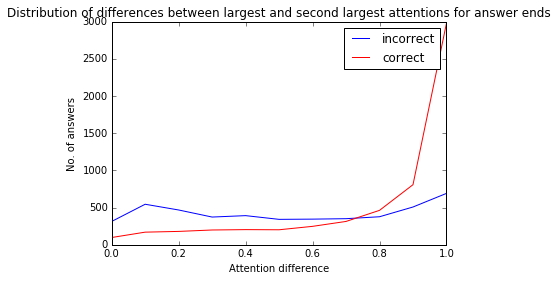

In [11]:
diff_values_correct, diff_values_incorrect = [], []
for qid in end_attentions:
    attn_distribution, _ = end_attentions[qid]
    if qid in wrong_qids:
        diff_values_incorrect.append(round(max(attn_distribution) - sorted(attn_distribution, reverse=True)[1], 1))
    else:
        diff_values_correct.append(round(max(attn_distribution) - sorted(attn_distribution, reverse=True)[1], 1))
counts_incorrect = Counter(diff_values_incorrect)
counts_correct = Counter(diff_values_correct)
handles = []
xs = sorted(counts_incorrect.keys())
ys = [ counts_incorrect[x] for x in xs ]
handles.append(plt.plot(xs, ys, 'b-', label="incorrect")[0])
xs = sorted(counts_correct.keys())
ys = [ counts_correct[x] for x in xs ]
handles.append(plt.plot(xs, ys, 'r-', label="correct")[0])
plt.legend(handles=handles)
plt.title("Distribution of differences between largest and second largest attentions for answer ends")
plt.ylabel("No. of answers")
plt.xlabel("Attention difference")
plt.show()

In [12]:
# Measure OOV ration difference in paragraphs for correct and incorrect questions.
done_paraidxs = set()
incorrect_oov, incorrect_count = 0, 0
correct_oov, correct_count = 0, 0
for qid in questions:
    if qid_to_paraidx[qid] in done_paraidxs:
        continue
    done_paraidxs = done_paraidxs.union([qid_to_paraidx[qid]])
    tokenized_para = word_tokenize(paragraphs[qid_to_paraidx[qid]])
    oov_ratio = len(set([ x for x in tokenized_para \
                        if not x in glove_vocab ])) / float(len(set(tokenized_para)))
    if qid in wrong_qids:
        incorrect_oov += oov_ratio
        incorrect_count += 1
    else:
        correct_oov += oov_ratio
        correct_count += 1
print "Across paragraphs with at least one incorrect question, OOV ratio = {0:.2f}%"\
      .format(100 * incorrect_oov/incorrect_count)
print "Across paragraphs with all correct questions, OOV ratio = {0:.2f}%"\
      .format(100 * correct_oov/correct_count)

Across paragraphs with at least one incorrect question, OOV ratio = 1.67%
Across paragraphs with all correct questions, OOV ratio = 1.62%


In [13]:
# Measure OOV ration difference in correct and incorrect questions.
incorrect_oov, incorrect_count = 0, 0
correct_oov, correct_count = 0, 0
for qid in questions:
    tokenized_q = word_tokenize(questions[qid])
    oov_ratio = len(set([ x for x in tokenized_q \
                        if not x in glove_vocab ])) / float(len(set(tokenized_q)))
    if qid in wrong_qids:
        incorrect_oov += oov_ratio
        incorrect_count += 1
    else:
        correct_oov += oov_ratio
        correct_count += 1
print "Average OOV ratio of incorrect questions = {0:.2f}%"\
      .format(100 * incorrect_oov/incorrect_count)
print "Average OOV ration of correct questions = {0:.2f}%"\
      .format(100 * correct_oov/correct_count)

Average OOV ratio of incorrect questions = 0.99%
Average OOV ration of correct questions = 0.75%


Examples with full F1: 55.48%
Examples with zero F1: 17.15%
Examples with partial F1: 27.37%


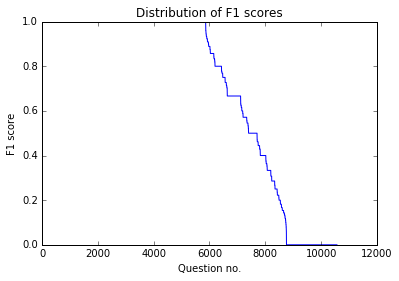

In [14]:
f1_distribution = sorted(predicted_f1s.values(), reverse=True)
plt.plot(np.arange(len(f1_distribution)), f1_distribution, 'b-')
plt.title("Distribution of F1 scores")
plt.ylabel("F1 score")
plt.xlabel("Question no.")

all_correct = len([ x for x in f1_distribution if x == 1.0 ])
zero = len([ x for x in f1_distribution if x == 0.0 ])
fraction = len(f1_distribution) - (all_correct + zero)

print "Examples with full F1: {0:.2f}%".format(all_correct * 100.0 / len(f1_distribution))
print "Examples with zero F1: {0:.2f}%".format(zero * 100.0 / len(f1_distribution))
print "Examples with partial F1: {0:.2f}%".format(fraction * 100.0 / len(f1_distribution))
plt.show()

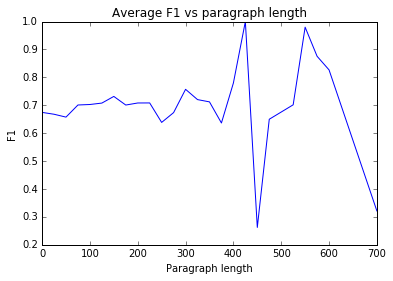

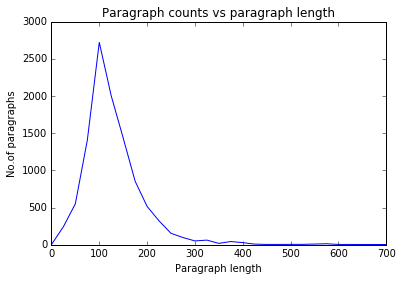

In [15]:
para_len_f1s = {}
bucket_size = 25
for qid in predicted_f1s:
    para_id = qid_to_paraidx[qid]
    para_len = len(tokenized_paras[para_id])//bucket_size
    if not para_len in para_len_f1s:
        para_len_f1s[para_len] = [0, 0]
    para_len_f1s[para_len][0] += predicted_f1s[qid]
    para_len_f1s[para_len][1] += 1
    
xs = sorted(para_len_f1s.keys())
para_counts = {}
for para_len in para_len_f1s:
    para_counts[para_len] = para_len_f1s[para_len][1]
    para_len_f1s[para_len] = para_len_f1s[para_len][0]/float(para_len_f1s[para_len][1])
ys = [ para_len_f1s[x] for x in xs ]
plt.plot(np.array(xs) * bucket_size, ys, 'b-')
plt.title("Average F1 vs paragraph length")
plt.ylabel("F1")
plt.xlabel("Paragraph length")
plt.show()

ys = [ para_counts[x] for x in xs ]
plt.plot(np.array(xs) * bucket_size, ys, 'b-')
plt.title("Paragraph counts vs paragraph length")
plt.ylabel("No.of paragraphs")
plt.xlabel("Paragraph length")
plt.show()

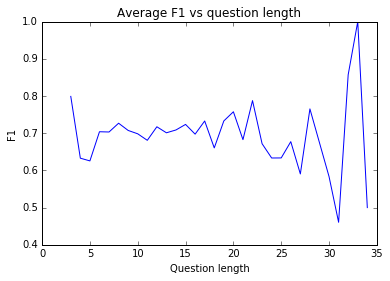

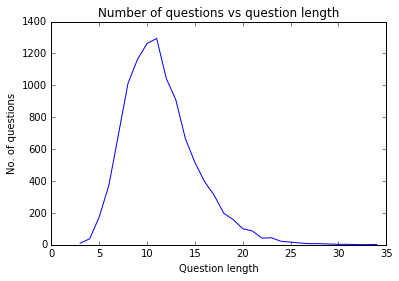

In [16]:
q_len_f1s = {}
for qid in predicted_f1s:
    q_len = len(word_tokenize(questions[qid]))
    if not q_len in q_len_f1s:
        q_len_f1s[q_len] = [0, 0]
    q_len_f1s[q_len][0] += predicted_f1s[qid]
    q_len_f1s[q_len][1] += 1
    
xs = sorted(q_len_f1s.keys())
q_counts = {}
for q_len in q_len_f1s:
    q_counts[q_len] = q_len_f1s[q_len][1]
    q_len_f1s[q_len] = q_len_f1s[q_len][0]/float(q_len_f1s[q_len][1])
ys = [ q_len_f1s[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Average F1 vs question length")
plt.ylabel("F1")
plt.xlabel("Question length")
plt.show()

ys = [ q_counts[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Number of questions vs question length")
plt.ylabel("No. of questions")
plt.xlabel("Question length")
plt.show()

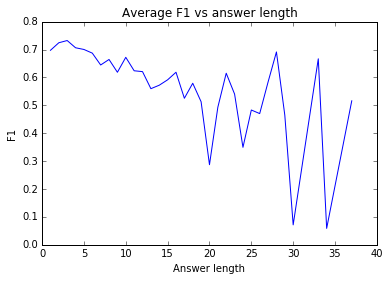

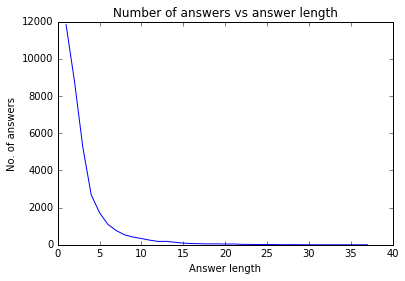

In [17]:
ans_len_f1s = {}
for _, ans_idxs, qid, _ in dev_input:
    ans_len = ans_idxs[1]-ans_idxs[0]+1
    if not ans_len in ans_len_f1s:
        ans_len_f1s[ans_len] = [0, 0]
    ans_len_f1s[ans_len][0] += predicted_f1s[qid]
    ans_len_f1s[ans_len][1] += 1
    
xs = sorted(ans_len_f1s.keys())
ans_counts = {}
for ans_len in ans_len_f1s:
    ans_counts[ans_len] = ans_len_f1s[ans_len][1]
    ans_len_f1s[ans_len] = ans_len_f1s[ans_len][0]/float(ans_len_f1s[ans_len][1])
ys = [ ans_len_f1s[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Average F1 vs answer length")
plt.ylabel("F1")
plt.xlabel("Answer length")
plt.show()

ys = [ ans_counts[x] for x in xs ]
plt.plot(xs, ys, 'b-')
plt.title("Number of answers vs answer length")
plt.ylabel("No. of answers")
plt.xlabel("Answer length")
plt.show()

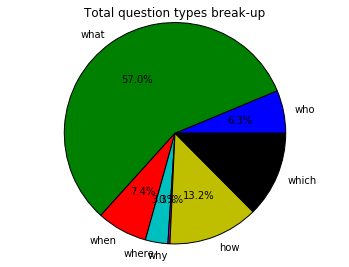

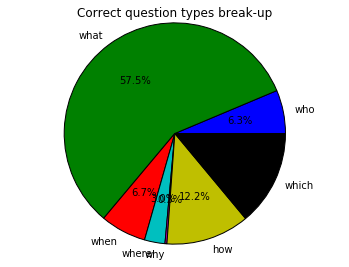

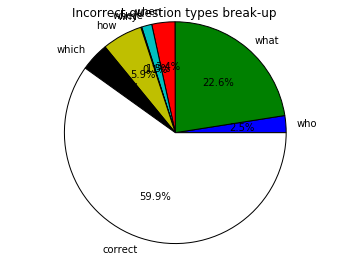

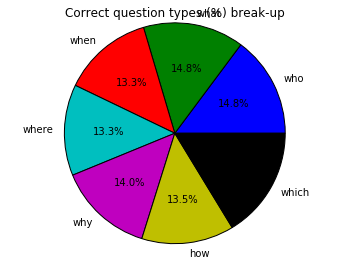

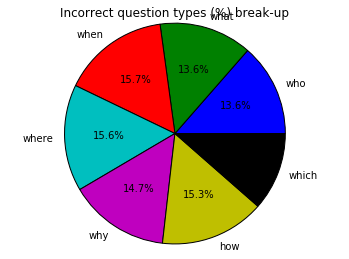

In [18]:
labels = ["who", "what", "when", "where", "why", "how", "which"]
totals = [0, 0, 0, 0, 0, 0, 0]
corrects = [0, 0, 0, 0, 0, 0, 0]
incorrects = [0, 0, 0, 0, 0, 0, 0]

for qid in predicted_f1s:
    for i, label in enumerate(labels):
        if label in questions[qid]:
            totals[i] += 1
            if predicted_f1s[qid] < 1.0:
                incorrects[i] += 1
            elif predicted_f1s[qid] == 1.0:
                corrects[i] += 1

fig1, ax1 = plt.subplots()
ax1.pie(totals, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Total question types break-up")
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(corrects, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Correct question types break-up")
plt.show()


fig1, ax1 = plt.subplots()
ax1.pie(incorrects + [sum(corrects)], labels=labels + ["correct"], autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Incorrect question types break-up")
plt.show()

totals, corrects, incorrects = \
    np.array(totals).astype(np.float32), np.array(corrects), np.array(incorrects)
fig1, ax1 = plt.subplots()
ax1.pie(corrects/totals, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Correct question types (%) break-up")
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie(incorrects/totals, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Incorrect question types (%) break-up")
plt.show()

In [19]:
any_oov = 0
all_oov = 0
incorrect_all_oov = 0
incorrect_any_oov = 0
total = 0
all_oov_list = []
for _, ans_idxs, qid, _ in dev_input:
    total += 1
    para = tokenized_paras[qid_to_paraidx[qid]]
    ans = [ dev_data.dictionary.get_word(para[idx]) \
              for idx in range(ans_idxs[0], ans_idxs[1]+1) ]
    is_oov = [ ans_word not in glove_vocab for ans_word in ans ]
    any_oov += any(is_oov)
    all_oov += all(is_oov)
    if any(is_oov):
        if predicted_f1s[qid] < 1.0:
            incorrect_any_oov += 1
    if all(is_oov):
        if predicted_f1s[qid] < 1.0:
            incorrect_all_oov += 1
        all_oov_list.append(" ".join(ans))
print "Answers with at-least one OOV word: {0:.2f}%".format(100 * any_oov/float(total))
print "Incorrect answers with at-least one OOV word: {0:.2f}%".format(100 * incorrect_any_oov/float(any_oov))
print "Answers with all OOV words: {0:.2f}%".format(100 * all_oov/float(total))
print "Incorrect answers with all OOV words: {0:.2f}%".format(100 * incorrect_all_oov/float(all_oov))
random.shuffle(all_oov_list)
print "All OOV list sample (%d):\n" % len(all_oov_list), "\n".join(all_oov_list[:10])

Answers with at-least one OOV word: 7.23%
Incorrect answers with at-least one OOV word: 50.26%
Answers with all OOV words: 2.85%
Incorrect answers with all OOV words: 50.66%
All OOV list sample (989):
prétendus réformés
1754–1763
Tayichi'ud
1919–1980
1919–1980
cryptomonads
Tomingaj
WJRT-TV
nitroaereus
nitroaereus


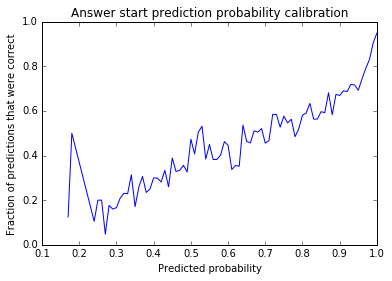

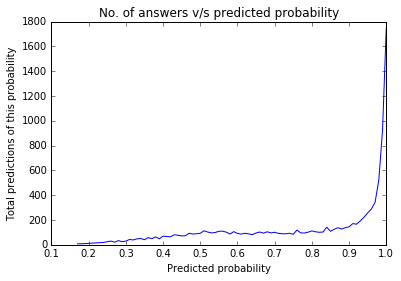

In [20]:
# Probability calibration
correct = {}
total = {}
attn_values = set()
for qid in start_attentions:
    attn_distribution, true_starts = start_attentions[qid]
    attn_value = round(max(attn_distribution), 2)
    if np.argmax(attn_distribution) in true_starts:
        if attn_value not in correct:
            correct[attn_value] = 1
        else:
            correct[attn_value] += 1
    if attn_value not in total:
        total[attn_value] = 1
    else:
        total[attn_value] += 1
    attn_values = attn_values.union([attn_value])

for attn_value in correct:
    correct[attn_value] /= float(total[attn_value])

xs = sorted([ x for x in list(attn_values) if x in correct ])
ys = [ correct[x] for x in xs if x in correct ]
plt.plot(xs, ys, 'b-')
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of predictions that were correct")
plt.title("Answer start prediction probability calibration")
plt.show()

ytotals = [ total[x] for x in xs if x in correct ]
plt.plot(xs, ytotals, 'b-')
plt.xlabel("Predicted probability")
plt.ylabel("Total predictions of this probability")
plt.title("No. of answers v/s predicted probability")
plt.show()

In [21]:
# MatchLSTM -> 72.5 (1030s)
# Our R-NET -> 74.5 (5500s)
# Our model (MatchLSTM + question attention for answer pointer) -> 73.7 (1300s)
# Our model (MatchLSTM + question attention for answer pointer + Custom Loss) -> 70.4 (1285s)